## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [14]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [15]:
train, test = keras.datasets.cifar10.load_data()

In [16]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [17]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [18]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [19]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [20]:
import tensorflow as tf
import keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(ce_weights,gamma=2, alpha=4.):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    ce_weights =float(ce_weights)
    epsilon = 1e-8
    def combined_loss(y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.math.add(y_pred, epsilon)
        ce = tf.math.multiply(y_true, -tf.math.log(model_out))
        weight = tf.math.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.math.multiply(alpha, tf.math.multiply(weight, ce))
        reduced_fl = tf.math.multiply(0.3,tf.math.reduce_mean(tf.math.reduce_max(fl, axis=1)))
        
        CE = tf.math.multiply(ce_weights,ce)
        reduced_ce =  tf.math.multiply(0.7,tf.math.reduce_mean(tf.math.reduce_max(CE, axis=1)))
        return tf.math.add(reduced_fl,reduced_ce)

    return  combined_loss


    return  combined_loss    
    
    
ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

In [11]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ce_weights=ce_w), metrics=["accuracy"], optimizer=optimizer)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, ce_weight: 0.00
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128) 

Epoch 44/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.3944 - acc: 0.8550 - val_loss: 1.7864 - val_acc: 0.4737
Epoch 45/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.3771 - acc: 0.8610 - val_loss: 1.8177 - val_acc: 0.4782
Epoch 46/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.3596 - acc: 0.8686 - val_loss: 1.8269 - val_acc: 0.4740
Epoch 47/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.3456 - acc: 0.8747 - val_loss: 1.8310 - val_acc: 0.4817
Epoch 48/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.3304 - acc: 0.8814 - val_loss: 1.9032 - val_acc: 0.4673
Epoch 49/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.3165 - acc: 0.8857 - val_loss: 1.9103 - val_acc: 0.4759
Epoch 50/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.3015 - acc: 0.8934 - val_loss: 1.9009 - val_acc: 0.4728
Numbers of exp: 2, ce_weight: 0.50

Epoch 41/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.4644 - acc: 0.8818 - val_loss: 2.3105 - val_acc: 0.4872
Epoch 42/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.4422 - acc: 0.8886 - val_loss: 2.3210 - val_acc: 0.4825
Epoch 43/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.4183 - acc: 0.8964 - val_loss: 2.4029 - val_acc: 0.4728
Epoch 44/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.4014 - acc: 0.9031 - val_loss: 2.3975 - val_acc: 0.4789
Epoch 45/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.3797 - acc: 0.9106 - val_loss: 2.4145 - val_acc: 0.4838
Epoch 46/50
50000/50000 [==============================] - 1s 28us/step - loss: 0.3607 - acc: 0.9157 - val_loss: 2.4343 - val_acc: 0.4816
Epoch 47/50
50000/50000 [==============================] - 1s 27us/step - loss: 0.3426 - acc: 0.9230 - val_loss: 2.5477 - val_acc: 0.4664
Epoch 48/50
50000/50000 [=========

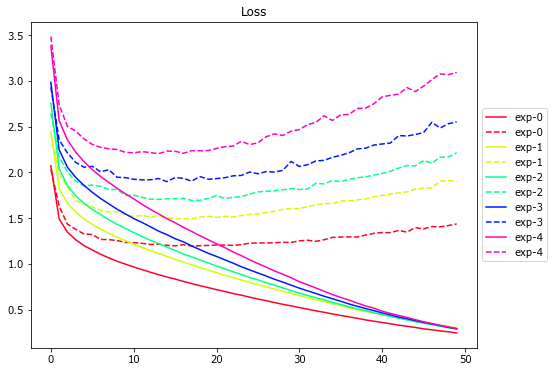

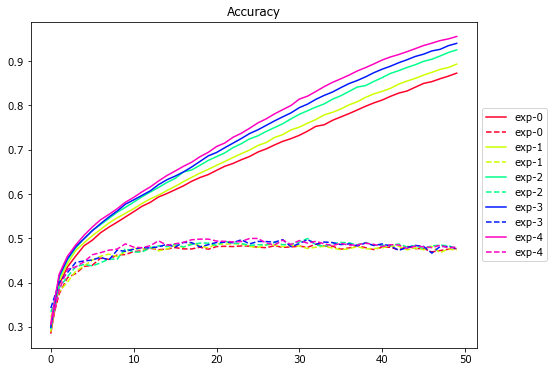

In [21]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()